Ланч-бокс с приборами двухуровневый 11410122

In [1]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

import copy
from copy import deepcopy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


------------

In [3]:
data = pd.read_csv('/content/11410122.csv', sep=';')

In [4]:
data

,Дата,Продажи,Остаток,Цена,Со скидкой и промо,Скидка,Цена со скидкой,Промокод,СПП,Цена с СПП,Сумма продаж,Комментариев,Рейтинг
0,2022-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-06-15,3,410.0,2442.0,561.0,77.0,561.0,0.0,0.0,561.0,1683,332.0,4.0
2,2022-06-14,1,413.0,2442.0,561.0,77.0,561.0,0.0,0.0,561.0,561,332.0,4.0
3,2022-06-13,3,413.0,2442.0,561.0,77.0,561.0,0.0,0.0,561.0,1683,332.0,4.0
4,2022-06-12,6,412.0,2442.0,561.0,77.0,561.0,0.0,0.0,561.0,3366,332.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Среднее (в день),6 шт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3 458,14 ₽",NaN,NaN
96,Дней с наличием,88 дней,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,Среднее при наличии,6 шт,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"3 548,08 ₽",NaN,NaN
98,Потенциал,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"339 881,00 ₽",NaN,NaN


Данные за период с 15.03.2022 по 15.06.2022 

In [5]:
data = data[1:94]

In [6]:
data.duplicated().sum()

0

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 1 to 93
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Дата                93 non-null     object 
 1   Продажи             93 non-null     object 
 2   Остаток             93 non-null     float64
 3   Цена                93 non-null     float64
 4   Со скидкой и промо  93 non-null     float64
 5   Скидка              93 non-null     float64
 6   Цена со скидкой     93 non-null     float64
 7   Промокод            93 non-null     float64
 8   СПП                 93 non-null     float64
 9   Цена с СПП          93 non-null     float64
 10  Сумма продаж        93 non-null     object 
 11  Комментариев        93 non-null     float64
 12  Рейтинг             93 non-null     float64
dtypes: float64(10), object(3)
memory usage: 9.6+ KB


In [8]:
data['Дата'] = pd.to_datetime(data['Дата'], format='%Y-%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
data = data.sort_values(by='Дата')

In [10]:
data = data.set_index('Дата')

In [11]:
data['Продажи'] = data['Продажи'].astype('int')
data['Сумма продаж'] = data['Сумма продаж'].astype('float64')

In [12]:
data.describe()

,Продажи,Остаток,Цена,Со скидкой и промо,Скидка,Цена со скидкой,Промокод,СПП,Цена с СПП,Сумма продаж,Комментариев,Рейтинг
count,93.000000,93.000000,93.0,93.000000,93.000000,93.000000,93.0,93.0,93.000000,93.000000,93.000000,93.0
mean,5.903226,279.537634,2442.0,588.215054,75.892473,588.215054,0.0,0.0,588.215054,3458.139785,321.096774,4.0
std,3.887171,163.598698,0.0,39.861404,1.638281,39.861404,0.0,0.0,39.861404,2288.672610,9.308790,0.0
min,0.000000,0.000000,2442.0,488.000000,74.000000,488.000000,0.0,0.0,488.000000,0.000000,307.000000,4.0
25%,3.000000,140.000000,2442.0,561.000000,75.000000,561.000000,0.0,0.0,561.000000,1758.000000,311.000000,4.0
50%,5.000000,381.000000,2442.0,586.000000,76.000000,586.000000,0.0,0.0,586.000000,3050.000000,322.000000,4.0
75%,9.000000,428.000000,2442.0,610.000000,77.000000,610.000000,0.0,0.0,610.000000,5072.000000,329.000000,4.0
max,19.000000,472.000000,2442.0,634.000000,80.000000,634.000000,0.0,0.0,634.000000,11134.000000,332.000000,4.0


In [13]:
data = data.drop(['Со скидкой и промо', 'Промокод', 'СПП', 'Цена с СПП'], axis=1)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2022-03-15 to 2022-06-15
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Продажи          93 non-null     int64  
 1   Остаток          93 non-null     float64
 2   Цена             93 non-null     float64
 3   Скидка           93 non-null     float64
 4   Цена со скидкой  93 non-null     float64
 5   Сумма продаж     93 non-null     float64
 6   Комментариев     93 non-null     float64
 7   Рейтинг          93 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 6.5 KB


In [15]:
data.isna().sum()

Продажи            0
Остаток            0
Цена               0
Скидка             0
Цена со скидкой    0
Сумма продаж       0
Комментариев       0
Рейтинг            0
dtype: int64

In [16]:
data

,Продажи,Остаток,Цена,Скидка,Цена со скидкой,Сумма продаж,Комментариев,Рейтинг
Дата,,,,,,,,
2022-03-15,8,213.0,2442.0,74.0,634.0,5072.0,307.0,4.0
2022-03-16,4,209.0,2442.0,74.0,634.0,2536.0,307.0,4.0
2022-03-17,6,204.0,2442.0,74.0,634.0,3804.0,307.0,4.0
2022-03-18,2,203.0,2442.0,74.0,634.0,1268.0,307.0,4.0
2022-03-19,7,198.0,2442.0,74.0,634.0,4438.0,307.0,4.0
...,...,...,...,...,...,...,...,...
2022-06-11,3,416.0,2442.0,77.0,561.0,1683.0,332.0,4.0
2022-06-12,6,412.0,2442.0,77.0,561.0,3366.0,332.0,4.0
2022-06-13,3,413.0,2442.0,77.0,561.0,1683.0,332.0,4.0


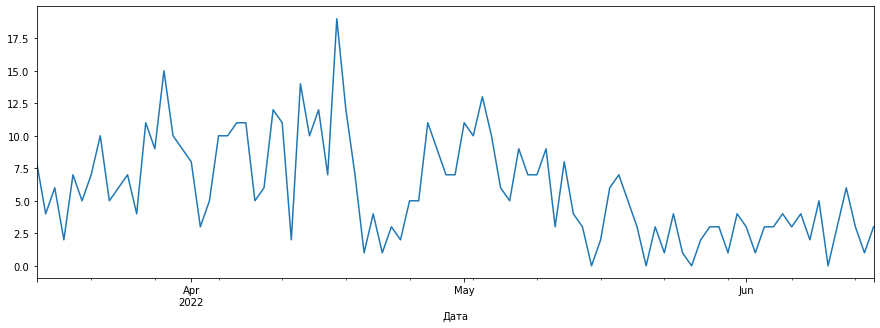

In [17]:
data['Продажи'].plot(figsize=(15,5))

Проведем сезонную декомпозицию.

In [18]:
decomposed = seasonal_decompose(data['Продажи'])

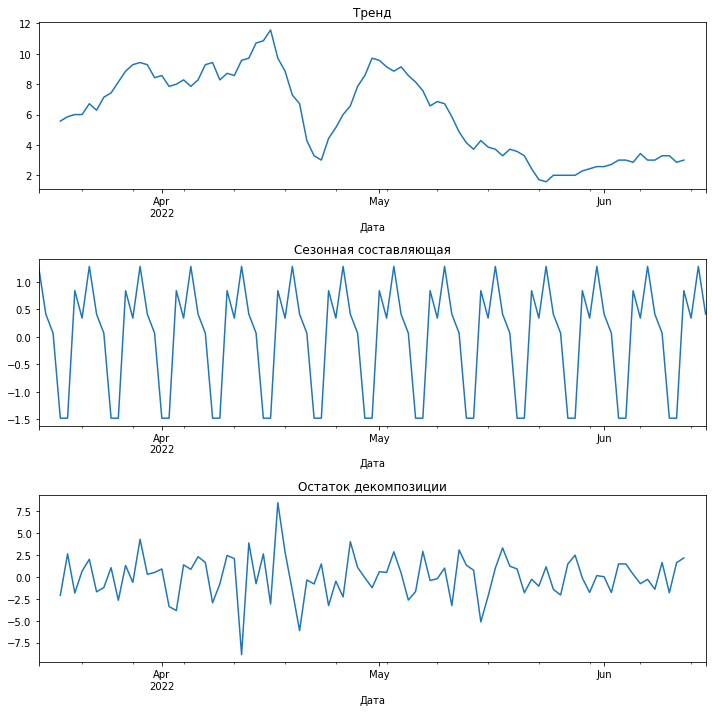

In [19]:
plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонная составляющая')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток декомпозиции')

plt.tight_layout()

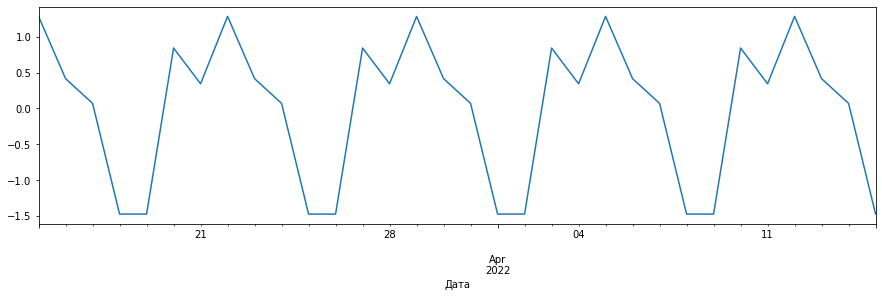

In [20]:
decomposed.seasonal['2022-03-15':'2022-04-15'].plot(figsize=(15, 4)) 

Создадим новые признаки для пострения моделей машинного обучения: календарные (месяц, день, день недели), отстающие значения (до 7 дней), скользящее среднее.

In [21]:
def make_features_new(data, max_lag, rolling_mean_size): # создание признаков

    data_features = deepcopy(data)

    data_features['month'] = data_features.index.month
    data_features['day'] = data_features.index.day
    data_features['dayofweek'] = data_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_features['lag_' + str(lag)] = data_features['Продажи'].shift(lag)

    data_features['rolling_mean'] = data_features['Продажи'].shift().rolling(rolling_mean_size).mean()
    
    return data_features

In [22]:
data_features = make_features_new(data, 7, 3)

In [23]:
data_features.columns

Index(['Продажи', 'Остаток', 'Цена', 'Скидка', 'Цена со скидкой',
       'Сумма продаж', 'Комментариев', 'Рейтинг', 'month', 'day', 'dayofweek',
       'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'rolling_mean'],
      dtype='object')

In [24]:
data_features[['Продажи','lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'rolling_mean']].head(10)

,Продажи,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
Дата,,,,,,,,,
2022-03-15,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-16,4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-17,6,4.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-18,2,6.0,4.0,8.0,NaN,NaN,NaN,NaN,6.000000
2022-03-19,7,2.0,6.0,4.0,8.0,NaN,NaN,NaN,4.000000
2022-03-20,5,7.0,2.0,6.0,4.0,8.0,NaN,NaN,5.000000
2022-03-21,7,5.0,7.0,2.0,6.0,4.0,8.0,NaN,4.666667
2022-03-22,10,7.0,5.0,7.0,2.0,6.0,4.0,8.0,6.333333
2022-03-23,5,10.0,7.0,5.0,7.0,2.0,6.0,4.0,7.333333


In [25]:
data_features = data_features.dropna()

----------

-------

Обучение

Разделим исходные данные на обучающую, валидационную и тестовую выборки. Делим в отношении 8 : 1 : 1.

In [26]:
features = data_features.drop(['Продажи'], axis=1) # признаки
target = data_features['Продажи'] # целевой признак

In [27]:
features.shape, target.shape

((86, 18), (86,))

In [28]:
# отделим 10% данных для тестовой выборки, данные не перемешиваем
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False) 

In [29]:
# отделим 10% данных для валидационной выборки, данные не перемешиваем
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.111, shuffle=False) 

----------

In [30]:
tscv = TimeSeriesSplit() # cv для cross_val_score и GridSearchCV для временных рядов

In [31]:
def RMSE(target, predictions): # функция для вычисления RMSE
    return (mean_squared_error(target, predictions) ** 0.5)

In [32]:
scoring = make_scorer(RMSE, greater_is_better=False) # scoring=scoring для cross_val_score

In [33]:
df = [] # таблица с результатами
col_data = ['model', 'type_data', 'RMSE']

In [34]:
def predict_result(model, features, target, type_data, name_model): # функция метрики на предсказании

    predictions = model.predict(features) # получим предсказания модели 
    
    result = RMSE(target, predictions) # значение метрики RMSE 
    
#    print("RMSE ", name_model, ":", result)
    
    df.append([name_model, type_data, result])

In [35]:
def plot_test_prediction_result(model, features, target, type_data,  name_model): # тестирование и визуализация

    predictions = model.predict(features) # получим предсказания модели 
    
    result = RMSE(target, predictions) # значение метрики RMSE 
    
    print("RMSE ", name_model, ":", result)
    
    df.append([name_model, type_data, result])   

    pred = pd.DataFrame(data=predictions, index = target.index)
  
    plt.figure(figsize=(12,6))
    plt.plot(target, color='green', label='test')
    plt.plot(pred, color='red', label='predictions')
    plt.title(name_model)
    #plt.xlabel('Date')
    #plt.ylabel('')
    plt.legend()
    plt.show()

--------------

CatBoostRegressor

In [36]:
parameters_CBR = {'loss_function': 'RMSE', # значение по умолчанию
                  'iterations': 1000, # значение по умолчанию
                  'random_state': 12345,
                  'verbose': 500}

model_CBR = CatBoostRegressor(**parameters_CBR)

grid = {'learning_rate': [0.01],
        'depth': [4, 6]}

grid_search_result = model_CBR.grid_search(grid, 
                                           X=features_train, 
                                           y=target_train, cv=tscv)

0:	learn: 8.5878454	test: 3.3704082	best: 3.3704082 (0)	total: 46.8ms	remaining: 46.7s
500:	learn: 0.9231907	test: 1.8041629	best: 1.8041629 (500)	total: 227ms	remaining: 226ms
999:	learn: 0.3264455	test: 1.4321683	best: 1.4321323 (998)	total: 428ms	remaining: 0us

bestTest = 1.432132324
bestIteration = 998

0:	loss: 1.4321323	best: 1.4321323 (0)	total: 460ms	remaining: 460ms
0:	learn: 8.5952972	test: 3.4112233	best: 3.4112233 (0)	total: 1.36ms	remaining: 1.36s
500:	learn: 0.9540261	test: 1.7391027	best: 1.7391027 (500)	total: 353ms	remaining: 351ms
999:	learn: 0.2593245	test: 1.5404866	best: 1.5403899 (998)	total: 752ms	remaining: 0us

bestTest = 1.540389882
bestIteration = 998

1:	loss: 1.5403899	best: 1.4321323 (0)	total: 1.24s	remaining: 0us
Estimating final quality...
Training on fold [0/5]
0:	learn: 8.4150566	test: 9.7936098	best: 9.7936098 (0)	total: 320us	remaining: 320ms
500:	learn: 1.3084952	test: 4.9340913	best: 4.9340913 (500)	total: 345ms	remaining: 344ms
999:	learn: 0.357

In [37]:
model_CBR.fit(features_train, target_train)

0:	learn: 4.0300364	total: 773us	remaining: 773ms
500:	learn: 0.6540033	total: 490ms	remaining: 488ms
999:	learn: 0.2566428	total: 948ms	remaining: 0us


In [38]:
 model_CBR.best_score_['learn']['RMSE']

0.2566427785580091

In [39]:
df.append(['CatBoostRegressor', 'train', model_CBR.best_score_['learn']['RMSE']])

-------

XGBRegressor

In [40]:
params = { #'eval_metric': "rmse"
          'max_depth': [6, 8], # 5, 6, 10, 15, 20],
          'learning_rate': [0.3], # 0.1, 0.2, 0.3],
           #'subsample': 0.8,
     #      'colsample_bytree': np.arange(0.4, 1.0, 0.1),
     #      'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100]
}

In [41]:
model_ = XGBRegressor()

In [42]:
model_XGBR = GridSearchCV(model_, params, cv=tscv, scoring=scoring, verbose=1)

In [43]:
model_XGBR.fit(features_train, target_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[09:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:02] WARNING: /workspace/src/objective/regres

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.3], 'max_depth': [6, 8],
                         'n_estimators': [100]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=1)

In [44]:
model_XGBR.best_params_

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}

In [45]:
df.append(['XGBRegressor', 'train', abs(model_XGBR.best_score_)])

In [46]:
abs(model_XGBR.best_score_)

1.1521829403077828

-----------

LightGBMRegressor

In [47]:
Params = {
    'learning_rate': [0.1, 0.2],
    'num_leaves': [31, 50],
    'n_estimators': [100],
    'objective' : ['regression'],
    'random_state' : [12345] 
    }

In [48]:
model_ = lgb.LGBMRegressor()

In [49]:
model_LGBMR = GridSearchCV(model_, Params, scoring=scoring, cv=tscv, verbose=1)

In [50]:
model_LGBMR.fit(features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.2], 'n_estimators': [100],
                         'num_leaves': [31, 50], 'objective': ['regression'],
                         'random_state': [12345]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=1)

In [51]:
model_LGBMR.best_params_

{'learning_rate': 0.1,
 'n_estimators': 100,
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': 12345}

In [52]:
df.append(['LightGBMRegressor', 'train', abs(model_LGBMR.best_score_)])

In [53]:
abs(model_LGBMR.best_score_)

3.3035976628712853

-----------

RandomForestRegressor

In [54]:
best_modelRFR = None
best_depthRFR = 0
best_est = 0
best_rmseRFR = 10000

for est in range(1, 11, 2): # в цикле меняем гиперпараметр - максимальное количество деревьев
    for depth in range(1, 11, 2): # в цикле меняем гиперпараметр - максимальную глубину дерева

        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) # случайный лес
    
        score = abs(sum(cross_val_score(
            model, features_train, target_train, scoring=scoring, cv=tscv)) / 5)
    
        if score < best_rmseRFR:
            best_modelRFR = model
            best_depthRFR = depth
            best_est = est
            best_rmseRFR = score

            
print("Модель 'Случайный лес', RMSE: ", best_rmseRFR, 
      ", количество деревьев:", best_est, ", глубина дерева:", best_depthRFR)

Модель 'Случайный лес', RMSE:  1.207110663551227 , количество деревьев: 5 , глубина дерева: 3


In [55]:
best_modelRFR.fit(features_train, target_train)

RandomForestRegressor(max_depth=3, n_estimators=5, random_state=12345)

In [56]:
df.append(['RandomForestRegressor', 'train', best_rmseRFR])

-----------

LinearRegression

In [57]:
modelLinR = LinearRegression() # инициализируем модель LinearRegression

In [58]:
modelLinR.fit(features_train, target_train)

LinearRegression()

In [59]:
predict_result(modelLinR, features_train, target_train, 'train', 'LinearRegression')

----------

In [60]:
df_result = pd.DataFrame(data=df, columns=col_data) # таблица с результатами

In [61]:
df_result

,model,type_data,RMSE
0,CatBoostRegressor,train,0.256643
1,XGBRegressor,train,1.152183
2,LightGBMRegressor,train,3.303598
3,RandomForestRegressor,train,1.207111
4,LinearRegression,train,0.131374


Тестирование

In [62]:
model = [model_XGBR, 
         model_LGBMR, 
         best_modelRFR,
         modelLinR,
         model_CBR]
name_model = ['XGBRegressor', 
              'LightGBMRegressor',
              'RandomForestRegressor',
              'LinearRegression',
              'CatBoostRegressor']

In [63]:
df.append(['-', '-', '-'])

In [64]:
for _ in range(len(model)):
    predict_result(model[_], features_test, target_test, 'test', name_model[_])

In [65]:
df.append(['-', '-', '-'])

In [66]:
df_result = pd.DataFrame(data=df, columns=col_data) # таблица с результатами

In [67]:
df_result

,model,type_data,RMSE
0,CatBoostRegressor,train,0.256643
1,XGBRegressor,train,1.152183
2,LightGBMRegressor,train,3.303598
3,RandomForestRegressor,train,1.207111
4,LinearRegression,train,0.131374
5,-,-,-
6,XGBRegressor,test,0.832845
7,LightGBMRegressor,test,1.298981
8,RandomForestRegressor,test,0.372001
9,LinearRegression,test,0.32794


train + valid

Для улучшения качества моделей переобучим их на объединении трейна и валидации.

In [68]:
features_train_valid = pd.concat([features_train, features_valid])

------

In [69]:
model_XGBR.fit(features_train_valid, target_train_valid)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[09:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:08] WARNING: /workspace/src/objective/regres

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(),
             param_grid={'learning_rate': [0.3], 'max_depth': [6, 8],
                         'n_estimators': [100]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=1)

In [70]:
df.append(['XGBRegressor', 'train_valid', abs(model_XGBR.best_score_)])

---

In [71]:
model_LGBMR.fit(features_train_valid, target_train_valid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.2], 'n_estimators': [100],
                         'num_leaves': [31, 50], 'objective': ['regression'],
                         'random_state': [12345]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=1)

In [72]:
df.append(['LightGBMRegressor', 'train_valid', abs(model_LGBMR.best_score_)])

---------

In [73]:
best_modelRFR.fit(features_train_valid, target_train_valid)

RandomForestRegressor(max_depth=3, n_estimators=5, random_state=12345)

In [74]:
predict_result(
    best_modelRFR, features_train_valid, target_train_valid, 'train_valid', 'RandomForestRegressor')


------

In [75]:
modelLinR.fit(features_train_valid, target_train_valid)

LinearRegression()

In [76]:
predict_result(
    modelLinR, features_train_valid, target_train_valid, 'train_valid', 'LinearRegression')

------

In [77]:
model_CBR.fit(features_train_valid, target_train_valid)

0:	learn: 4.0067332	total: 984us	remaining: 983ms
500:	learn: 0.6398814	total: 547ms	remaining: 545ms
999:	learn: 0.2459973	total: 1.09s	remaining: 0us


In [78]:
df.append(['model_CBR', 'train_valid', model_CBR.best_score_['learn']['RMSE']])

In [79]:
df.append(['-', '-', '-'])

--------

Финальное тестирование и визуализация

In [80]:
name_model = ['XGBRegressor_train_valid', 
              'LightGBMRegressor_train_valid',
              'RandomForestRegressor_train_valid',
              'LinearRegression_train_valid',
              'CatBoostRegressor_train_valid']

RMSE  XGBRegressor_train_valid : 0.15507608994233857


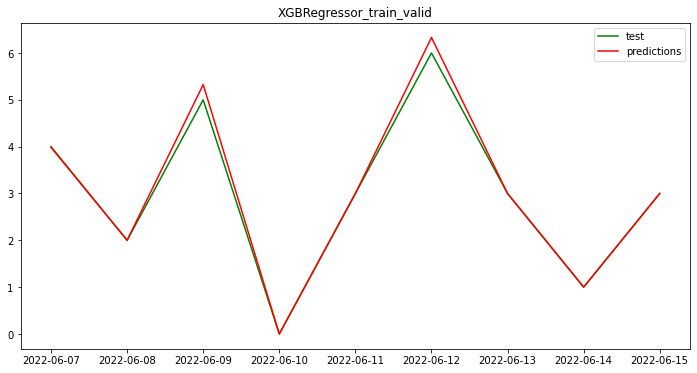

RMSE  LightGBMRegressor_train_valid : 1.2534174898328923


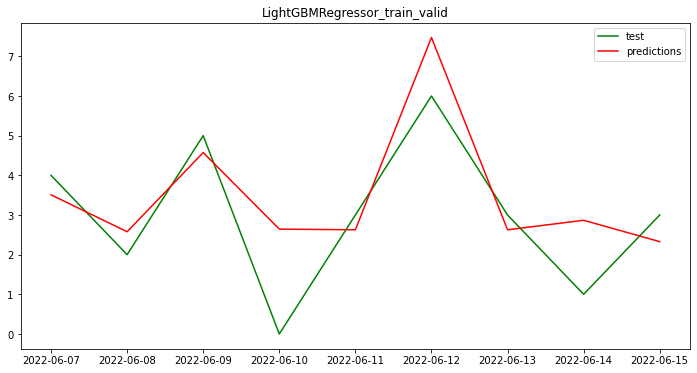

RMSE  RandomForestRegressor_train_valid : 0.4706097383659596


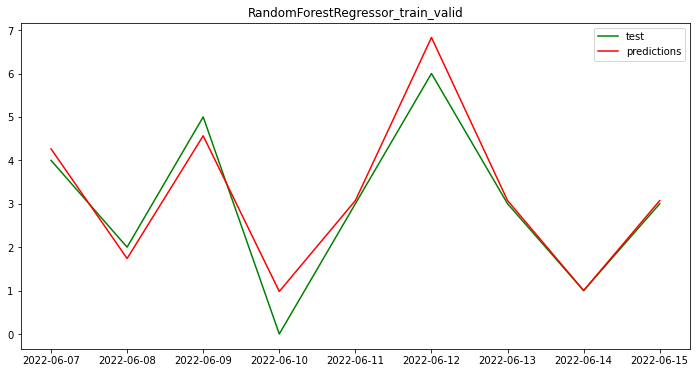

RMSE  LinearRegression_train_valid : 0.09778796793529762


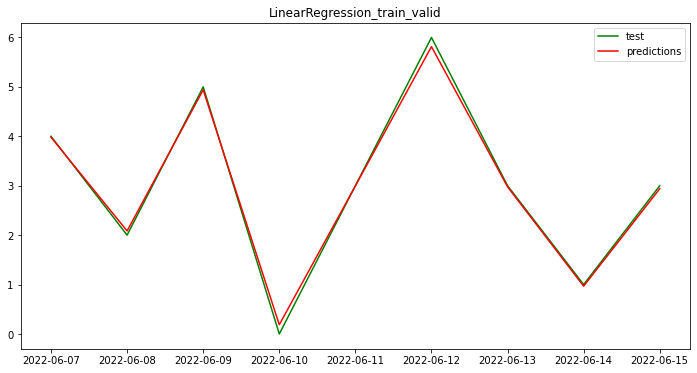

RMSE  CatBoostRegressor_train_valid : 0.4753819211213744


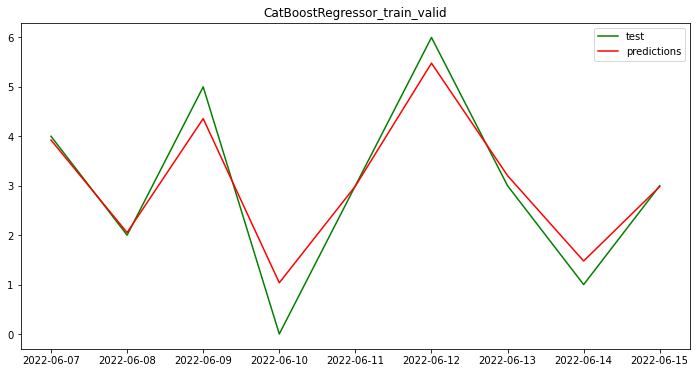

In [81]:
for _ in range(len(model)):
    plot_test_prediction_result(
    model[_], features_test, target_test, 'test', name_model[_])

In [82]:
df_result = pd.DataFrame(data=df, columns=col_data) # таблица с результатами

In [83]:
df_result

,model,type_data,RMSE
0,CatBoostRegressor,train,0.256643
1,XGBRegressor,train,1.152183
2,LightGBMRegressor,train,3.303598
3,RandomForestRegressor,train,1.207111
4,LinearRegression,train,0.131374
5,-,-,-
6,XGBRegressor,test,0.832845
7,LightGBMRegressor,test,1.298981
8,RandomForestRegressor,test,0.372001
9,LinearRegression,test,0.32794


In [84]:
model = [model_XGBR, 
         model_LGBMR, 
         best_modelRFR,
         modelLinR,
         model_CBR]

In [85]:
target_test

Дата
2022-06-07    4
2022-06-08    2
2022-06-09    5
2022-06-10    0
2022-06-11    3
2022-06-12    6
2022-06-13    3
2022-06-14    1
2022-06-15    3
Name: Продажи, dtype: int64

In [86]:
best_modelRFR.predict(features_test)

array([4.26475257, 1.73894737, 4.56475257, 0.98      , 3.07306502,
       6.83015873, 3.07306502, 1.        , 3.07306502])

--------------

In [87]:
features_test

,Остаток,Цена,Скидка,Цена со скидкой,Сумма продаж,Комментариев,Рейтинг,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
Дата,,,,,,,,,,,,,,,,,,
2022-06-07,417.0,2442.0,77.0,561.0,2244.0,332.0,4.0,6,7,1,3.0,4.0,3.0,3.0,1.0,3.0,4.0,3.333333
2022-06-08,417.0,2442.0,77.0,561.0,1122.0,332.0,4.0,6,8,2,4.0,3.0,4.0,3.0,3.0,1.0,3.0,3.666667
2022-06-09,416.0,2442.0,77.0,561.0,2805.0,332.0,4.0,6,9,3,2.0,4.0,3.0,4.0,3.0,3.0,1.0,3.000000
2022-06-10,416.0,2442.0,77.0,561.0,0.0,332.0,4.0,6,10,4,5.0,2.0,4.0,3.0,4.0,3.0,3.0,3.666667
2022-06-11,416.0,2442.0,77.0,561.0,1683.0,332.0,4.0,6,11,5,0.0,5.0,2.0,4.0,3.0,4.0,3.0,2.333333
2022-06-12,412.0,2442.0,77.0,561.0,3366.0,332.0,4.0,6,12,6,3.0,0.0,5.0,2.0,4.0,3.0,4.0,2.666667
2022-06-13,413.0,2442.0,77.0,561.0,1683.0,332.0,4.0,6,13,0,6.0,3.0,0.0,5.0,2.0,4.0,3.0,3.000000
2022-06-14,413.0,2442.0,77.0,561.0,561.0,332.0,4.0,6,14,1,3.0,6.0,3.0,0.0,5.0,2.0,4.0,4.000000
2022-06-15,410.0,2442.0,77.0,561.0,1683.0,332.0,4.0,6,15,2,1.0,3.0,6.0,3.0,0.0,5.0,2.0,3.333333


In [88]:
data_features

,Продажи,Остаток,Цена,Скидка,Цена со скидкой,Сумма продаж,Комментариев,Рейтинг,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
Дата,,,,,,,,,,,,,,,,,,,
2022-03-22,10,180.0,2442.0,74.0,634.0,6340.0,307.0,4.0,3,22,1,7.0,5.0,7.0,2.0,6.0,4.0,8.0,6.333333
2022-03-23,5,180.0,2442.0,74.0,634.0,3170.0,307.0,4.0,3,23,2,10.0,7.0,5.0,7.0,2.0,6.0,4.0,7.333333
2022-03-24,6,175.0,2442.0,74.0,634.0,3804.0,307.0,4.0,3,24,3,5.0,10.0,7.0,5.0,7.0,2.0,6.0,7.333333
2022-03-25,7,174.0,2442.0,74.0,634.0,4438.0,307.0,4.0,3,25,4,6.0,5.0,10.0,7.0,5.0,7.0,2.0,7.000000
2022-03-26,4,171.0,2442.0,74.0,634.0,2536.0,307.0,4.0,3,26,5,7.0,6.0,5.0,10.0,7.0,5.0,7.0,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-11,3,416.0,2442.0,77.0,561.0,1683.0,332.0,4.0,6,11,5,0.0,5.0,2.0,4.0,3.0,4.0,3.0,2.333333
2022-06-12,6,412.0,2442.0,77.0,561.0,3366.0,332.0,4.0,6,12,6,3.0,0.0,5.0,2.0,4.0,3.0,4.0,2.666667
2022-06-13,3,413.0,2442.0,77.0,561.0,1683.0,332.0,4.0,6,13,0,6.0,3.0,0.0,5.0,2.0,4.0,3.0,3.000000
